In [1]:
import torch
import umap
import numpy as np
import pandas as pd
import plotly.express as px
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from IPython import display

In [2]:
# MNIST is 28x28 (784)
input_w = 28
input_h = 28
input_dim = input_w * input_h
hidden_dim_1 = 512
hidden_dim_2 = 256
hidden_dim_3 = 128
latent_dim = 64
condition_dim = 10 # Number of classes (0 to 9)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
class VAE(nn.Module):
    def __init__(self, hidden_dim_1, hidden_dim_2, hidden_dim_3, latent_dim, input_dim):
        super(VAE, self).__init__()
        
        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Linear(input_dim + condition_dim, hidden_dim_1),
            nn.BatchNorm1d(hidden_dim_1),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim_1, hidden_dim_2),
            nn.BatchNorm1d(hidden_dim_2),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim_2, hidden_dim_3),
            nn.BatchNorm1d(hidden_dim_3),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim_3, hidden_dim_3),
            nn.BatchNorm1d(hidden_dim_3),
            nn.LeakyReLU(0.2),
        )
        self.fc_mean = nn.Linear(hidden_dim_3, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim_3, latent_dim)
        
        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + condition_dim, hidden_dim_3),
            nn.BatchNorm1d(hidden_dim_3),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim_3, hidden_dim_2),
            nn.BatchNorm1d(hidden_dim_2),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim_2, hidden_dim_1),
            nn.BatchNorm1d(hidden_dim_1),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim_1, input_dim),
            nn.Sigmoid()
        )
    
    def encode(self, x, y):
        xy = torch.cat([x, y], dim=1)
        h = self.encoder(xy)
        mean = self.fc_mean(h)
        logvar = self.fc_logvar(h)
        return mean, logvar
    
    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mean + eps * std
        return z
    
    def decode(self, z, y):
        zy = torch.cat([z, y], dim=1)
        return self.decoder(zy)
    
    def forward(self, x, y):
        mean, logvar = self.encode(x.view(-1, input_dim), y)
        z = self.reparameterize(mean, logvar)
        reconstructed_x = self.decode(z, y)
        return reconstructed_x, mean, logvar

In [5]:
def loss_function(recon_x, x, mean, logvar, beta=0.5):
    MSE = F.mse_loss(recon_x, x, reduction='sum')  # Try MSE instead of BCE
    KLD = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
    return MSE + beta * KLD

In [6]:
# Transform to normalize data to [0, 1]
transform = transforms.Compose([transforms.ToTensor()])

# Load MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

In [7]:
model = VAE(hidden_dim_1=hidden_dim_1, hidden_dim_2=hidden_dim_2, hidden_dim_3=hidden_dim_3, latent_dim=latent_dim, input_dim=input_dim).to(device)
model

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=794, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2)
    (9): Linear(in_features=128, out_features=128, bias=True)
    (10): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2)
  )
  (fc_mean): Linear(in_features=128, out_features=64, bias=True)
  (fc_logvar): Linear(in_features=128, out_features=64, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=74, out_feature

In [8]:
learning_rate = 0.0001
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3)
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.view(-1, input_dim).to(device)
        labels_onehot = F.one_hot(labels, num_classes=condition_dim).float().to(device)
        
        # Forward pass
        optimizer.zero_grad()
        reconstructed_batch, mean, logvar = model(data, labels_onehot)
        
        # Compute loss
        beta = min(epoch / 20, 1.0)
        loss = loss_function(reconstructed_batch, data, mean, logvar, beta)
        
        # Backward pass and optimize
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 5.0)  # Gradient clipping
        optimizer.step()

        train_loss += loss.item()

    scheduler.step(train_loss)
    avg_loss = train_loss / len(train_loader.dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}')

Epoch 1/50, Loss: 47.3948
Epoch 2/50, Loss: 23.6973
Epoch 3/50, Loss: 22.7433
Epoch 4/50, Loss: 22.8281
Epoch 5/50, Loss: 23.0608
Epoch 6/50, Loss: 23.3229
Epoch 7/50, Loss: 23.5353
Epoch 8/50, Loss: 23.8842
Epoch 9/50, Loss: 24.4618
Epoch 10/50, Loss: 24.9792
Epoch 11/50, Loss: 25.4964
Epoch 12/50, Loss: 25.9732
Epoch 13/50, Loss: 26.5642
Epoch 14/50, Loss: 27.1130
Epoch 15/50, Loss: 27.6154
Epoch 16/50, Loss: 28.0736
Epoch 17/50, Loss: 28.6436
Epoch 18/50, Loss: 29.1178
Epoch 19/50, Loss: 29.5739
Epoch 20/50, Loss: 30.0730
Epoch 21/50, Loss: 30.5406
Epoch 22/50, Loss: 30.4505
Epoch 23/50, Loss: 30.4411
Epoch 24/50, Loss: 30.4049
Epoch 25/50, Loss: 30.3653
Epoch 26/50, Loss: 30.3422
Epoch 27/50, Loss: 30.2563
Epoch 28/50, Loss: 30.2747
Epoch 29/50, Loss: 30.2686
Epoch 30/50, Loss: 30.2441
Epoch 31/50, Loss: 30.2403
Epoch 32/50, Loss: 30.1980
Epoch 33/50, Loss: 30.2654
Epoch 34/50, Loss: 30.1813
Epoch 35/50, Loss: 30.1970
Epoch 36/50, Loss: 30.2154
Epoch 37/50, Loss: 30.2385
Epoch 38/5

In [9]:
model.eval()

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=794, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2)
    (9): Linear(in_features=128, out_features=128, bias=True)
    (10): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2)
  )
  (fc_mean): Linear(in_features=128, out_features=64, bias=True)
  (fc_logvar): Linear(in_features=128, out_features=64, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=74, out_feature

In [10]:
def plot_latent_space_umap(model, data_loader, device):
    model.eval()
    latent_means = []
    labels = []
    
    with torch.no_grad():
        for data, label in data_loader:
            data = data.view(data.size(0), -1).to(device)
            label_onehot = F.one_hot(label, num_classes=condition_dim).float().to(device)
            _, mean, logvar = model(data, label_onehot)
            latent_means.append(mean.cpu())
            labels.append(label)
    
    latent_means = torch.cat(latent_means, dim=0).numpy()
    labels = torch.cat(labels, dim=0).numpy()

    # Use UMAP instead of PCA
    reducer = umap.UMAP(
        n_components=2,
        n_neighbors=20,       # Controls local vs global structure
        min_dist=0.1,         # Controls cluster tightness
        metric='euclidean',   # Distance metric
        random_state=42
    )
    latent_2d = reducer.fit_transform(latent_means)
    
    plt.figure(figsize=(12, 10))
    plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap='tab10', alpha=0.8) #cmap='tab10', alpha=0.6)
    plt.colorbar()
    plt.title('Latent Space Visualization (UMAP)')
    plt.show()

    return latent_means, labels

/home/fstp/github/setup_notebook_server/venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/fstp/github/setup_notebook_server/venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


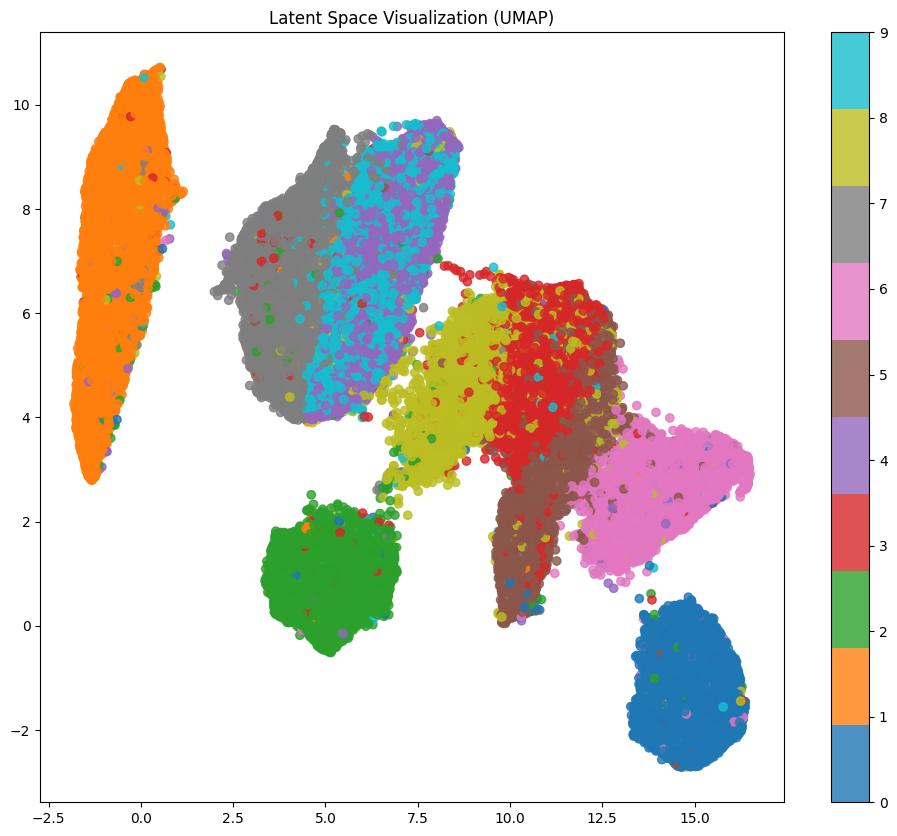

In [11]:
# Plot latent space using UMAP
latents, labels = plot_latent_space_umap(model, train_loader, device)

In [ ]:
l = 
y = F.one_hot(torch.tensor([label]), 10).float().to(device)

In [301]:
def plot_random_samples(width, height, figsize):
    """Generate random samples and plot them."""
    with torch.no_grad():
        y = F.one_hot(torch.tensor([label]), 10).float().to(device)
        z = torch.randn(width*height, latent_dim).to(device)
        sample = model.decode(z)
        sample = torch.sigmoid(sample)  # Convert logits to probabilities

    fig, axes = plt.subplots(width, height, figsize=figsize)
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(sample[i].cpu().view(input_w, input_h), cmap='gray')
        ax.axis('off')
    plt.show()

plot_random_samples(8, 8, figsize=(10,10))

TypeError: VAE.decode() missing 1 required positional argument: 'y'

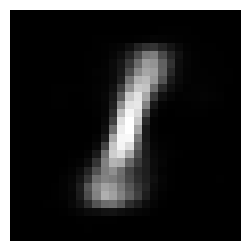

In [84]:
def generate_clean_sample(label, temp):
    model.eval()
    with torch.no_grad():
        z = torch.randn(1, 64).to(device) * temp  # Temperature scaling
        y = F.one_hot(torch.tensor([label]), 10).float().to(device)
        sample = model.decode(z, y).cpu().view(28, 28)
    return sample

generated_sample = generate_clean_sample(1, 0.2)
plt.figure(figsize=(3, 3))
plt.imshow(generated_sample, cmap='gray')
plt.axis('off')
plt.show()

In [85]:
def find_digit(num, data_loader):
    with torch.no_grad():
        for data in data_loader:
            imgs, labels = data
            matches = (labels == num).nonzero()
            if len(matches) > 0:
                idx = matches[0].item()
                return imgs[idx]

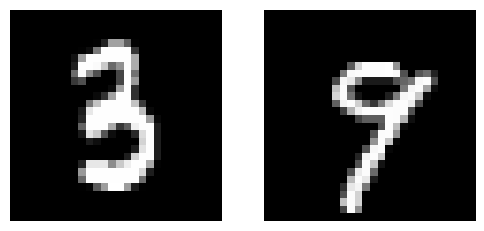

In [106]:
source_digit = 3
target_digit = 9

img_source = find_digit(source_digit, train_loader)
img_target = find_digit(target_digit, train_loader)

fig, axes = plt.subplots(1, 2, figsize=(6, 6))
axes[0].imshow(img_source.view(28, 28), cmap='gray')
axes[0].axis('off')
axes[1].imshow(img_target.view(28, 28), cmap='gray')
axes[1].axis('off')
plt.show()

In [110]:
def digit_to_latent_space(img, digit):
    with torch.no_grad():
        model.eval()
        x = img.view(1, 784).to(device)
        y = F.one_hot(torch.tensor([digit]), 10).float().to(device)
        mean, logvar = model.encode(x, y)
        z = model.reparameterize(mean, logvar)
        return z

In [117]:
def latent_space_to_digit(z, digit):
    with torch.no_grad():
        model.eval()
        y = F.one_hot(torch.tensor([digit]), 10).float().to(device)
        sample = model.decode(z, y)
        sample = torch.sigmoid(sample) # Convert logits to probabilities
        return sample.cpu().detach()

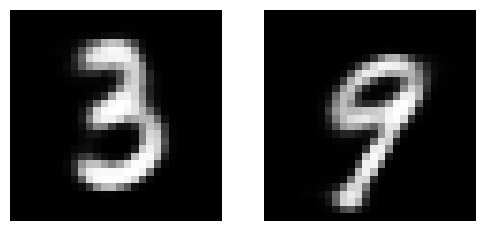

In [138]:
z_source = digit_to_latent_space(img_source, source_digit)
z_target = digit_to_latent_space(img_target, target_digit)

sampled_source = latent_space_to_digit(z_source, source_digit)
sampled_target = latent_space_to_digit(z_target, target_digit)

fig, axes = plt.subplots(1, 2, figsize=(6, 6))
axes[0].imshow(sampled_source.view(28, 28), cmap='gray')
axes[0].axis('off')
axes[1].imshow(sampled_target.view(28, 28), cmap='gray')
axes[1].axis('off')
plt.show()

In [145]:
from ipywidgets import interact, FloatSlider

morph_digit = source_digit

@interact(alpha=FloatSlider(min=0, max=1, step=0.01, value=0))
def show_morph(alpha):
    with torch.no_grad():
        z = (1 - alpha) * z_source + alpha * z_target
        y = F.one_hot(torch.tensor([morph_digit]), 10).float().to(device)
        sample = torch.sigmoid(model.decode(z, y)).cpu().detach().view(28, 28)
        plt.figure(figsize=(3, 3))
        plt.imshow(sample, cmap='gray')
        plt.axis('off')
        plt.show()

interactive(children=(FloatSlider(value=0.0, description='alpha', max=1.0, step=0.01), Output()), _dom_classes…

In [148]:
def sample_around_z(z_original, digit, num_samples=4, epsilon=1.0):
    """Generate samples around a latent vector `z_original`."""
    perturbed_zs = []
    
    for _ in range(num_samples):
        # Generate a random direction and normalize it
        direction = torch.randn_like(z_original)
        direction = direction / torch.norm(direction)
        
        # Perturb the original vector
        z_perturbed = z_original + epsilon * direction
        perturbed_zs.append(z_perturbed)
    
    # Decode all latent vectors
    with torch.no_grad():
        y = F.one_hot(torch.tensor([digit]), 10).float().to(device)
        samples = [torch.sigmoid(model.decode(z)) for z in perturbed_zs]

    return samples

In [159]:
from ipywidgets import interact, FloatSlider

img_source = find_digit(source_digit, train_loader)
z_source = digit_to_latent_space(img_source, source_digit)
direction = torch.randn_like(z_source)
direction = direction / torch.norm(direction)

@interact(epsilon=FloatSlider(min=0, max=10, step=0.01, value=0))
def show_morph_dir(epsilon):
    with torch.no_grad():
        z = z_source + epsilon * direction
        y = F.one_hot(torch.tensor([source_digit]), 10).float().to(device)
        sample = torch.sigmoid(model.decode(z, y)).cpu().detach().view(28, 28)
        fig, axes = plt.subplots(1, 2, figsize=(6, 6))
        axes[0].imshow(img_source.squeeze(), cmap='gray') 
        axes[0].axis('off')
        axes[1].imshow(sample, cmap='gray')
        axes[1].axis('off')
        plt.show()

interactive(children=(FloatSlider(value=0.0, description='epsilon', max=10.0, step=0.01), Output()), _dom_clas…

In [176]:
z_random = torch.randn(1, latent_dim).to(device)
img_target = find_digit(target_digit, train_loader)
z_target = digit_to_latent_space(img_target, target_digit)

@interact(alpha=FloatSlider(min=0, max=1, step=0.01, value=0))
def show_morph(alpha):
    with torch.no_grad():
        y = F.one_hot(torch.tensor([target_digit]), 10).float().to(device)
        z = (1 - alpha) * z_random + alpha * z_target
        sample = torch.sigmoid(model.decode(z, y)).cpu().detach().view(28, 28)
        fig, axes = plt.subplots(1, 2, figsize=(6, 6))
        axes[0].imshow(sample.view(28, 28), cmap='gray')
        axes[0].axis('off')
        axes[1].imshow(img_target.view(28, 28), cmap='gray')
        axes[1].axis('off')
        plt.show()

interactive(children=(FloatSlider(value=0.0, description='alpha', max=1.0, step=0.01), Output()), _dom_classes…